### Set plot style

In [13]:
sampler.download_sample('data/images',size=(600,600))

In [14]:
from fastai.vision.all import *

In [ ]:
!pip install -q pigeonXT-jupyter

In [16]:
images = get_image_files('data/images/')
images

(#513) [Path('data/images/txdn_fiji_ver01_data_sn88084272_00280765430_1915041601_0576_007_0_98.jpg'),Path('data/images/hihouml_azure_ver01_data_sn83025121_00211108861_1875102701_0345_001_0_96.jpg'),Path('data/images/kyu_judaspriest_ver01_data_sn84037890_00280763597_1885102101_0756_004_0_95.jpg'),Path('data/images/mimtptc_ionia_ver01_data_sn98066392_00296024508_1890112001_0147_012_0_95.jpg'),Path('data/images/dlc_2kandinsky_ver01_data_sn83045462_00280606510_1950092901_0517_003_0_93.jpg'),Path('data/images/az_gilamonster_ver01_data_sn87062055_0021110675A_1915102201_0060_004_0_96.jpg'),Path('data/images/ohi_edgar_ver01_data_sn85038121_00280775356_1870081801_0133_000_0_91.jpg'),Path('data/images/khi_ingalls_ver02_data_sn82014635_00237286698_1890112201_0644_005_0_91.jpg'),Path('data/images/hihouml_flying_ver01_data_sn82014681_00294552042_1885082901_0089_000_0_95.jpg'),Path('data/images/msar_emerald_ver02_data_sn87065614_00383343793_1890052201_0888_002_0_92.jpg')...]

In [17]:
from pigeonXT import annotate
from IPython.display import display, Image

In [25]:
annotations = annotate(images.items,
                       task_type='multilabel-classification',
                       options=['people'],
                       display_fn=lambda filename: display(Image(filename, height=400)))

HTML(value='0 of 513 Examples annotated, Current Position: 0 ')

Output()

In [ ]:
anno_df = pd.DataFrame({'fname':annotations.keys(),'label':annotations.values()})


In [67]:
#anno_df.to_csv('data/ads/labels.csv')

In [10]:
anno_df = pd.read_csv('data/ads/labels.csv',index_col=0)
anno_df

fname  \
0    data/ads/images/vtu_cauliflower_ver01_data_sn91066782_00415628146_1908071501_0089_006_6_96.jpg   
1    data/ads/images/curiv_knotgrass_ver01_data_sn82015099_00279556653_1860020401_0380_000_6_96.jpg   
2         data/ads/images/scu_idacox_ver02_data_sn84026853_00202194023_1874090201_0055_006_6_93.jpg   
3          data/ads/images/oru_jones_ver01_data_sn96061150_00200298408_1890061301_0580_010_6_90.jpg   
4            data/ads/images/ncu_dan_ver01_data_sn85042204_00296023073_1850031601_0449_002_6_92.jpg   
..                                                                                              ...   
390         data/ads/images/tu_nancy_ver01_data_sn85033673_00280779404_1872122101_1191_003_6_94.jpg   
391        data/ads/images/ohi_edgar_ver01_data_sn84028821_00280775496_1874031901_0273_001_6_97.jpg   
392        data/ads/images/in_chacha_ver03_data_sn87056247_0020029452A_1856012401_0034_003_6_93.jpg   
393        data/ads/images/ohi_india_ver01_data_sn85038161_00237289328_1900092001_0590_002_6_98.jpg   
394  data/ads/images/okhi_dillpickle_ver01_data_sn86063952_00295864400_1920050601_0046_004_6_94.jpg   

               label  
0    no_illustration  
1    no_illustration  
2       illustration  
3    no_illustration  
4       illustration  
..               ...  
390  no_illustration  
391     illustration  
392  no_illustration  
393     illustration  
394  no_illustration  

[395 rows x 2 columns]

In [11]:
def create_dls(gpu_resize, bs=128):
    b_tfms = aug_transforms(max_warp=0,size=gpu_resize, max_lighting=0,p_affine=0)
    return ImageDataLoaders.from_df(anno_df, bs=bs,fn_col='fname', label_col='label',
                               item_tfms=Resize(512,ResizeMethod.Squish),
                               batch_tfms=b_tfms)

In [12]:
dls = create_dls(128)

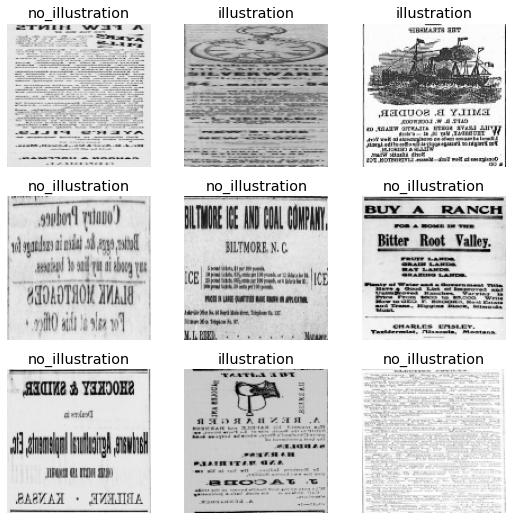

In [8]:
dls.show_batch()

In [37]:
learn = cnn_learner(dls, squeezenet1_0, metrics=[F1Score()]).to_fp16()

SuggestedLRs(lr_min=0.04365158379077912, lr_steep=0.0006918309954926372)

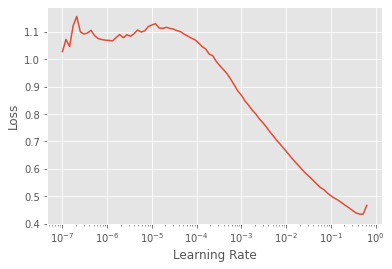

In [15]:
learn.lr_find()

In [38]:
learn.fit_one_cycle(20, lr_max=1e-2, 
                    cbs=[SaveModelCallback(monitor='f1_score'), 
                         ReduceLROnPlateau(monitor='f1_score',patience=3),
                         EarlyStoppingCallback(monitor='f1_score',patience=5),
                         MixUp()])

Better model found at epoch 0 with f1_score value: 0.0.
Better model found at epoch 1 with f1_score value: 0.03636363636363636.
Better model found at epoch 2 with f1_score value: 0.13793103448275862.
Better model found at epoch 3 with f1_score value: 0.8600000000000001.
Better model found at epoch 5 with f1_score value: 0.9433962264150944.
Better model found at epoch 7 with f1_score value: 0.9454545454545454.
Epoch 10: reducing lr to 0.0007033713192162134
Better model found at epoch 11 with f1_score value: 0.9532710280373832.
Epoch 14: reducing lr to 0.00029663863801806704
No improvement since epoch 11: early stopping


In [39]:
Path('data/ads_model').mkdir(exist_ok=True)

In [40]:
learn.path = Path('data/ads_model')

In [41]:
learn.save('stage-1')

Path('data/ads_model/models/stage-1.pth')

In [42]:
learn.validate()

(#2) [0.239297017455101,0.9532710280373832]

SuggestedLRs(lr_min=0.0015848932787775993, lr_steep=0.013182567432522774)

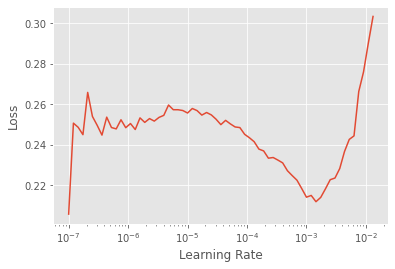

In [44]:
learn.unfreeze()
learn.lr_find()

In [45]:
learn.fit_one_cycle(10, lr_max=slice(1e-6,1e-4),
                    cbs=[SaveModelCallback(monitor='f1_score'), 
                         ReduceLROnPlateau(monitor='f1_score',patience=2),
                         EarlyStoppingCallback(monitor='f1_score',patience=2),
                         MixUp()])

Better model found at epoch 0 with f1_score value: 0.9532710280373832.
Epoch 2: reducing lr to 9.999999999999999e-06
No improvement since epoch 0: early stopping


In [46]:
interp = ClassificationInterpretation.from_learner(learn)

In [47]:
interp.print_classification_report()

                 precision    recall  f1-score   support

   illustration       0.92      0.88      0.90        26
no_illustration       0.94      0.96      0.95        53

       accuracy                           0.94        79
      macro avg       0.93      0.92      0.93        79
   weighted avg       0.94      0.94      0.94        79



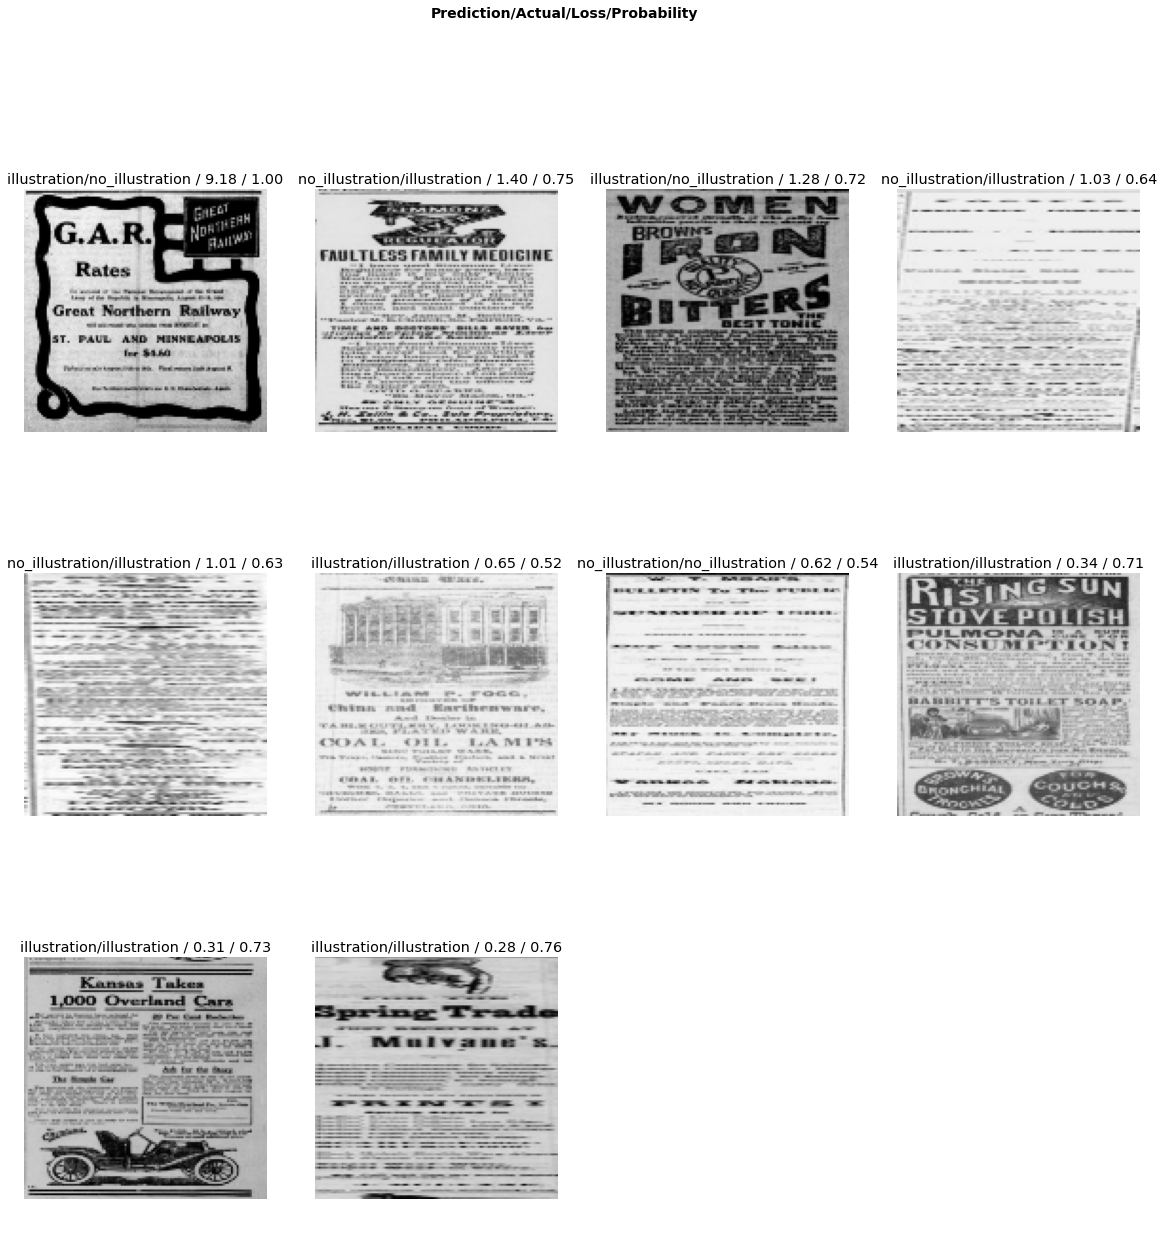

In [48]:
interp.plot_top_losses(10, figsize=(20,20))

In [49]:
#learn.export('export.pkl')

In [13]:
learn = load_learner('data/ads_model/export.pkl')

In [14]:
learn.dls = dls

In [15]:
from nnanno.inference import *

In [16]:
learn.model.to('cuda');

In [17]:
learn

In [18]:
predictor = nnPredict(learn, try_gpu=True)

In [ ]:
predictor.predict_sample('ads','data/ad_inference2/',0.01,start_year=1900, end_year=1920,step=10, bs=32,force_dir=True)

simple 